## Finilizing Data Generation for 0D Reactor

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

pd.options.mode.chained_assignment = None  # default='warn'

from PCAfold import PCA as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_500Cases_Simple/'
# TestDir    = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
# try:
#     os.makedirs(TestDir)
# except OSError as e:
#     pass

NVarsRed           = 10

tStratch           = 1.
SOLVER             = 'BDF'

valid_perc          = 20.

FixedMinVal        = 1.e-14

POD_NAME           = '3'
iPC                = 2

if (POD_NAME == 'All'):
    n_modesFinal = 64
    PODType    = 'All'
else:
    n_modesFinal = 32
    PODType    = 'OneByOne'
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType))
except:
    pass

In [3]:
FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics         = len(ICVecs)

In [4]:
if (POD_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(n_ics):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]]


        Flg = True
        for iPC in range(NVarsRed):
            if (np.abs( (DataTemp['PC_'+str(iPC+1)][0] - DataTemp['PC_'+str(iPC+1)][len(Data)-1])/DataTemp['PC_'+str(iPC+1)][0] ) < 1.e-4): 
                Flg = False
                break
        
        if Flg:
            DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols += [str(iC+1)+'_PC_'+str(iPC+1) for iPC in range(NVarsRed)]
            
        else:
            print('iC ', iC)

    tVec              = Data['t']
    DataInput.columns = Cols
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(n_ics):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data['PC_'+str(iPC+1)]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-4):
            DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [5]:
ICs = DataIC.to_numpy()

In [6]:
DataInput

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.043368,-0.047896,0.010202,-0.011962,-0.024042,-0.055523,-0.029479,-0.068433,0.086496,0.064006,...,-0.101806,-0.057208,-0.068772,-0.029197,-0.019915,-0.089204,-0.000946,-0.044827,-0.066228,-0.022473
1,0.043368,-0.047896,0.010202,-0.011962,-0.024042,-0.055523,-0.029479,-0.068433,0.086496,0.064006,...,-0.101806,-0.057208,-0.068772,-0.029197,-0.019915,-0.089204,-0.000946,-0.044827,-0.066228,-0.022473
2,0.043368,-0.047896,0.010202,-0.011962,-0.024042,-0.055523,-0.029479,-0.068433,0.086496,0.064006,...,-0.101806,-0.057208,-0.068772,-0.029197,-0.019915,-0.089204,-0.000946,-0.044827,-0.066228,-0.022473
3,0.043368,-0.047896,0.010202,-0.011962,-0.024042,-0.055523,-0.029479,-0.068433,0.086496,0.064006,...,-0.101806,-0.057208,-0.068772,-0.029197,-0.019915,-0.089204,-0.000946,-0.044827,-0.066228,-0.022473
4,0.043368,-0.047896,0.010202,-0.011962,-0.024042,-0.055523,-0.029479,-0.068433,0.086496,0.064006,...,-0.101806,-0.057208,-0.068772,-0.029197,-0.019915,-0.089204,-0.000946,-0.044827,-0.066228,-0.022473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.055717,-0.089832,-0.064570,-0.068084,-0.087799,-0.106758,-0.084357,-0.106327,-0.030160,-0.035389,...,-0.117909,-0.094718,-0.115255,-0.091342,-0.073125,-0.115362,-0.077571,-0.106776,-0.094536,-0.077091
4996,-0.055717,-0.089832,-0.064570,-0.068085,-0.087799,-0.106758,-0.084357,-0.106327,-0.030161,-0.035391,...,-0.117909,-0.094718,-0.115255,-0.091342,-0.073125,-0.115362,-0.077571,-0.106776,-0.094536,-0.077091
4997,-0.055717,-0.089832,-0.064570,-0.068086,-0.087799,-0.106758,-0.084357,-0.106327,-0.030161,-0.035393,...,-0.117909,-0.094718,-0.115255,-0.091342,-0.073126,-0.115362,-0.077571,-0.106776,-0.094537,-0.077091
4998,-0.055717,-0.089832,-0.064570,-0.068087,-0.087799,-0.106758,-0.084357,-0.106327,-0.030162,-0.035395,...,-0.117910,-0.094718,-0.115255,-0.091342,-0.073126,-0.115362,-0.077571,-0.106776,-0.094538,-0.077092


In [7]:
DataIC

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,-15.281970,0.124368,0.043368,-0.010778,0.026075,-0.019167,-0.002034,0.001852,9.007016e-07,0.000144
1,-23.949733,0.000676,-0.047896,-0.008560,-0.004345,0.010591,0.003179,0.000397,-8.921439e-05,-0.000139
2,-20.014083,0.054131,0.010202,-0.002544,0.004616,-0.003715,-0.000303,0.001335,3.764361e-07,0.000015
3,-24.371366,-0.011903,-0.011962,0.008568,-0.017582,0.010114,0.000731,0.000998,2.436516e-05,-0.000091
4,-18.467993,0.084407,-0.024042,-0.024239,0.024755,-0.006614,0.002148,0.000754,-1.311689e-04,-0.000012
...,...,...,...,...,...,...,...,...,...,...
495,-24.488576,-0.001221,-0.089204,-0.023445,0.004141,0.014140,0.005888,-0.000286,-1.989339e-04,-0.000212
496,-16.874993,0.106111,-0.000946,-0.021981,0.028504,-0.012384,0.000767,0.001127,-9.613212e-05,0.000050
497,-16.055123,0.126347,-0.044827,-0.044328,0.046674,-0.012696,0.003789,0.000391,-2.410419e-04,-0.000004
498,-26.831166,-0.042394,-0.066228,-0.002761,-0.017954,0.019911,0.004108,0.000113,-8.409130e-05,-0.000215


In [8]:
# n_modes      = 128
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# plt.figure(figsize=(8,8))
# for j, Scaling in enumerate(ScalingVec):

#     pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes))
#     C          = pca.X_center
#     D          = pca.X_scale
#     A          = pca.A[:,0:n_modes].T
#     L          = pca.L
#     AT         = A.T

#     plt.plot(L, label=Scaling)
    
# plt.ylim([1.e-14, 1.e0])
# plt.yscale('log')
# plt.legend()

In [9]:
# n_modesVec   = np.arange(30,150,10)
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# MaxPerc    = np.zeros((len(n_modesVec), len(ScalingVec)))
# MaxSE      = np.zeros((len(n_modesVec), len(ScalingVec)))
# MeanPerc   = np.zeros((len(n_modesVec), len(ScalingVec)))
# MSE        = np.zeros((len(n_modesVec), len(ScalingVec)))
# for i, n_modes in enumerate(n_modesVec):
#     #print('n_modes = ', n_modes)
    
#     for j, Scaling in enumerate(ScalingVec):

#         pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes))
#         C          = pca.X_center
#         D          = pca.X_scale
#         A          = pca.A[:,0:n_modes].T
#         L          = pca.L
#         AT         = A.T

#         yMat_pca   = ((yMat - C)/D).dot(AT)
#         yMat_      = (yMat_pca.dot(A))*D + C
        
#         MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
#         MaxSE[i,j]      = np.max((yMat - yMat_)**2)
#         MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
#         MSE[i,j]        = np.mean((yMat - yMat_)**2)

# plt.figure(figsize=(8,8))
# plt.plot(n_modesVec, MaxPerc, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Max % Error')
# plt.legend()
# plt.yscale('log')

# plt.figure(figsize=(8,8))
# plt.plot(n_modesVec, MaxSE, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Max Squared Error')
# plt.legend()
# plt.yscale('log')

# plt.figure(figsize=(8,8))
# plt.plot(n_modesVec, MeanPerc, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Mean % Error')
# plt.legend()
# plt.yscale('log')

# plt.figure(figsize=(8,8))
# plt.plot(n_modesVec, MSE, label=ScalingVec)
# plt.xlabel('No of PODs')
# plt.ylabel('Mean Squared Error')
# plt.legend()
# plt.yscale('log')

In [10]:
#n_modesFinal = 64

pca        = PCAA(yMat, scaling='none', n_components=n_modesFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:n_modesFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (32, 500)
[PCA] 


In [11]:
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

In [12]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (5000, 32)
[PCA]  Max % Error =  20235.441992357024
[PCA]  Max      SE =  2.8419267681938907e-08
[PCA] Mean % Error =  0.04243079616218756
[PCA]          MSE =  3.376081355451069e-11


In [13]:
# #%matplotlib qt

# iVar    = 2

# fig = plt.figure()
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(ICs[:,0], ICs[:,1], A[iVar,:], c='k')
# ax.set_xlabel(r'$\eta_{'+str(1)+'}$')
# ax.set_ylabel(r'$\eta_{'+str(2)+'}$')
# ax.set_zlabel(r'$\Psi_{'+str(iVar+1)+'}$')

In [14]:
ICs.shape

(500, 10)

In [15]:
A.shape

(32, 500)

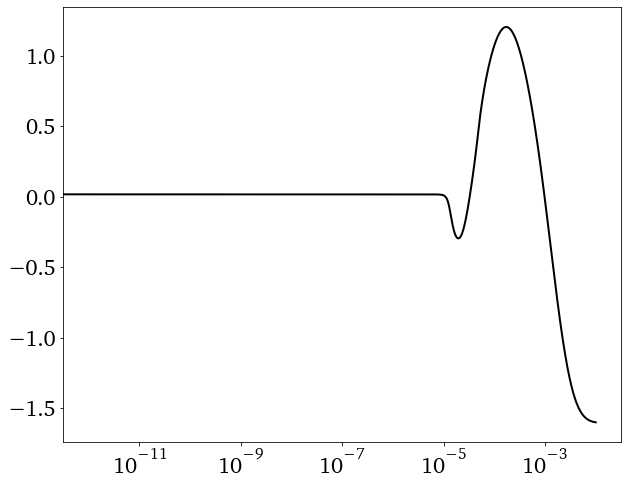

In [16]:
plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,0], '-k')
plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

(1e-06, 0.01)

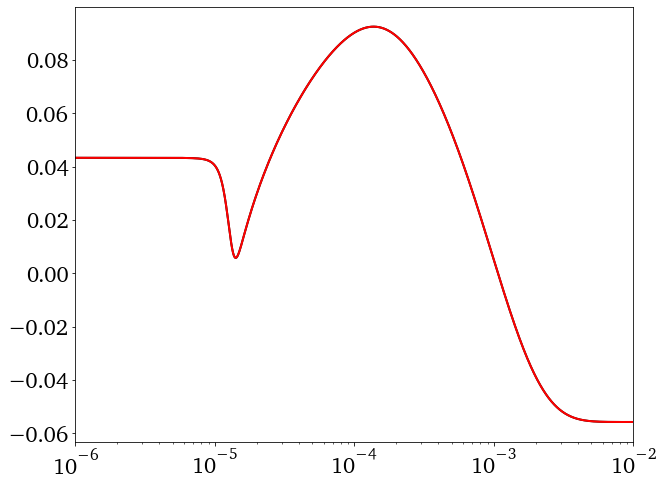

In [17]:
plt.figure(figsize=(10,8))
plt.plot(tVec, yMat[:,0], '-k')
plt.plot(tVec, yMat_[:,0], '-r')
plt.xscale('log')
plt.xlim([1.e-6,1.e-2])

In [18]:
Vars             = ['POD_'+str(i_mode+1) for i_mode in range(n_modesFinal)]
Data             = pd.DataFrame(yMat_pca, columns=Vars)
tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

,POD_1,POD_2,POD_3,POD_4,POD_5,POD_6,POD_7,POD_8,POD_9,POD_10,...,POD_26,POD_27,POD_28,POD_29,POD_30,POD_31,POD_32,t,log(t),log10(t)
0,0.015931,-0.100361,0.009723,0.002803,-0.000191,-0.004448,-0.002055,0.001957,-0.001229,0.000733,...,0.000011,-0.000010,0.000006,-0.000006,0.000004,0.000002,0.000004,1.000000e-14,-32.236191,-14.000000
1,0.015931,-0.100361,0.009723,0.002803,-0.000191,-0.004448,-0.002055,0.001957,-0.001229,0.000733,...,0.000011,-0.000010,0.000006,-0.000006,0.000004,0.000002,0.000004,1.000000e-12,-27.631021,-12.000000
2,0.015931,-0.100361,0.009723,0.002803,-0.000191,-0.004448,-0.002055,0.001957,-0.001229,0.000733,...,0.000011,-0.000010,0.000006,-0.000006,0.000004,0.000002,0.000004,1.097499e-12,-27.537987,-11.959596
3,0.015931,-0.100361,0.009723,0.002803,-0.000191,-0.004448,-0.002055,0.001957,-0.001229,0.000733,...,0.000011,-0.000010,0.000006,-0.000006,0.000004,0.000002,0.000004,1.204504e-12,-27.444954,-11.919192
4,0.015931,-0.100361,0.009723,0.002803,-0.000191,-0.004448,-0.002055,0.001957,-0.001229,0.000733,...,0.000011,-0.000010,0.000006,-0.000006,0.000004,0.000002,0.000004,1.321941e-12,-27.351920,-11.878788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.600942,-0.008347,0.149997,0.011989,-0.025303,0.044614,0.008095,-0.012583,0.002582,-0.007079,...,0.000157,0.000028,0.000128,0.000008,0.000487,-0.000453,-0.000118,9.887808e-03,-4.616453,-2.004900
4996,-1.601011,-0.008431,0.150065,0.011997,-0.025345,0.044690,0.008112,-0.012606,0.002582,-0.007097,...,0.000159,0.000028,0.000130,0.000008,0.000494,-0.000460,-0.000120,9.915738e-03,-4.613632,-2.003675
4997,-1.601079,-0.008514,0.150132,0.012006,-0.025386,0.044766,0.008127,-0.012628,0.002583,-0.007115,...,0.000161,0.000029,0.000132,0.000009,0.000501,-0.000467,-0.000122,9.943746e-03,-4.610811,-2.002450
4998,-1.601147,-0.008597,0.150198,0.012014,-0.025427,0.044842,0.008143,-0.012651,0.002584,-0.007133,...,0.000163,0.000029,0.000134,0.000009,0.000509,-0.000474,-0.000123,9.971833e-03,-4.607991,-2.001225


In [19]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/')
except:
    pass

In [20]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [21]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Output.csv', index=False)

In [22]:
from sklearn.model_selection import train_test_split

for i_mode in range(NVarsRed):
    POD_NAME = str(i_mode+1)
     
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
    except:
        pass

In [23]:
data_id    = 'pts'

n_points             = len(DataIC)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=valid_perc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


for i_mode in range(NVarsRed):
    POD_NAME = str(i_mode+1)
     
    Mask = np.arange(i_mode,A.shape[1],NVarsRed)

    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
    except:
        pass

    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/')
    except:
        pass

    DataInput  = DataIC
    DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Input.csv', index=False)
    DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Input.csv', index=False)

    DataOutput = pd.DataFrame(np.concatenate([A[:,Mask].T, C[Mask,np.newaxis], D[Mask,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
    DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Output.csv', index=False)
    DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Output.csv', index=False)

IndexError: positional indexers are out-of-bounds

In [ ]:
n_points             = len(DataIC)

n_test               = n_points


for i_mode in range(NVarsRed):
    POD_NAME = str(i_mode+1)
    
    Mask = np.arange(i_mode,A.shape[1],NVarsRed)
     
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
    except:
        pass
    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
    except:
        pass

    try:
        os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/')
    except:
        pass

    DataInput  = DataIC
    DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Input.csv', index=False)

    DataOutput = pd.DataFrame(np.concatenate([A[:,Mask].T, C[Mask,np.newaxis], D[Mask,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
    DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Output.csv', index=False)

In [ ]:
# NComp = 2

# pca        = PCAA(ICs, scaling='none', n_components=NComp)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:NComp].T
# L          = pca.L
# AT         = A.T
# print('[PCA] Shape of A        = ', A.shape)
# print('[PCA] ')

In [ ]:
# #yMat_pca    = pca.transform(yMat, nocenter=False)
# ICs_pca   = ((ICs - C)/D).dot(AT)

# ICs_      = (ICs_pca.dot(A))*D + C
# print('[PCA] Shape of yMat_pca = ', ICs_pca.shape)
# print('[PCA]  Max % Error = ', np.max(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]  Max      SE = ', np.max((ICs - ICs_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]          MSE = ', np.mean((ICs - ICs_)**2))

In [ ]:
#A 